In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import os
import requests
import io

# Ensure necessary libraries are installed in Google Colab
try:
    import shap
except ImportError:
    !pip install shap
    import shap

try:
    import lime
    import lime.lime_tabular
except ImportError:
    !pip install lime
    import lime
    import lime.lime_tabular

# 1. 加载数据
file_url = "https://raw.githubusercontent.com/LeonSu070/datasets/refs/heads/main/wdbc.data.csv"
df = pd.read_csv(file_url, header=0, names=[
    "ID", "Diagnosis",
    "Mean Radius", "Mean Texture", "Mean Perimeter", "Mean Area", "Mean Smoothness",
    "Mean Compactness", "Mean Concavity", "Mean Concave Points", "Mean Symmetry", "Mean Fractal Dimension",
    "SE Radius", "SE Texture", "SE Perimeter", "SE Area", "SE Smoothness",
    "SE Compactness", "SE Concavity", "SE Concave Points", "SE Symmetry", "SE Fractal Dimension",
    "Worst Radius", "Worst Texture", "Worst Perimeter", "Worst Area", "Worst Smoothness",
    "Worst Compactness", "Worst Concavity", "Worst Concave Points", "Worst Symmetry", "Worst Fractal Dimension"
])

# 2. 数据预处理
df.drop(columns=["ID"], inplace=True)  # 移除 ID 列
df["Diagnosis"] = df["Diagnosis"].map({"M": 1, "B": 0})  # 转换诊断标签

# 确保所有特征列为数值类型
df.iloc[:, 1:] = df.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
df.dropna(inplace=True)  # 处理缺失值



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=089306767ceb5ff18b6ddad684c2022b1be45d236f0fdfe55e77282de9402859
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


<ipython-input-3-f3ab3f23b944>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Diagnosis"], palette="coolwarm")


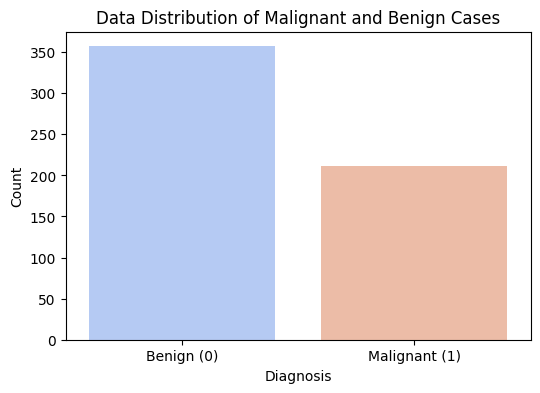

In [3]:
# 4. Data visualization (class distribution)
plt.figure(figsize=(6, 4))
sns.countplot(x=df["Diagnosis"], palette="coolwarm")
plt.xticks([0, 1], ["Benign (0)", "Malignant (1)"])
plt.title("Data Distribution of Malignant and Benign Cases")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()

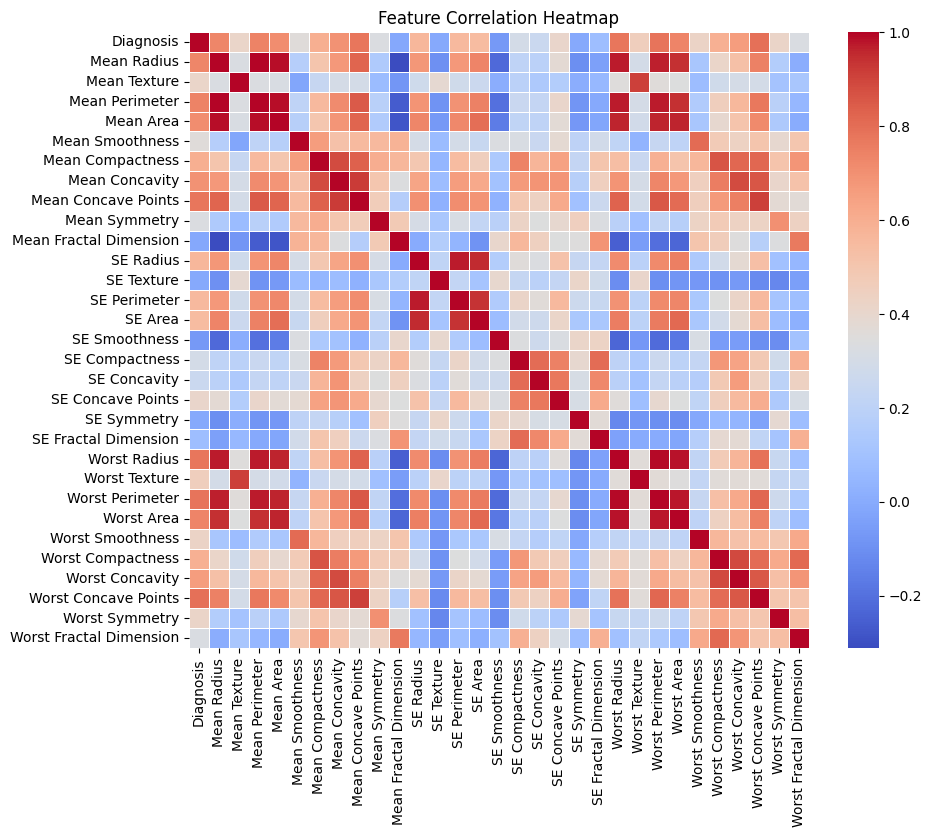

In [4]:
# 5. Correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False, linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [5]:
# 6. Standardize data
scaler = StandardScaler()
X = df.drop(columns=["Diagnosis"])

# X = df.drop(columns=[ "Diagnosis",
#     "Mean Radius", "Mean Texture", "Mean Perimeter", "Mean Area", "Mean Smoothness",
#     "Mean Compactness", "Mean Concavity", "Mean Concave Points", "Mean Symmetry", "Mean Fractal Dimension",
#     "SE Radius", "SE Texture", "SE Perimeter", "SE Area", "SE Smoothness",
#     "SE Compactness", "SE Concavity", "SE Concave Points", "SE Symmetry", "SE Fractal Dimension"
#     #"Worst Radius", "Worst Texture", "Worst Perimeter", "Worst Area", "Worst Smoothness",
#     #"Worst Compactness", "Worst Concavity", "Worst Concave Points", "Worst Symmetry", "Worst Fractal Dimension"
#     ])

y = df["Diagnosis"]
X_scaled = scaler.fit_transform(X)


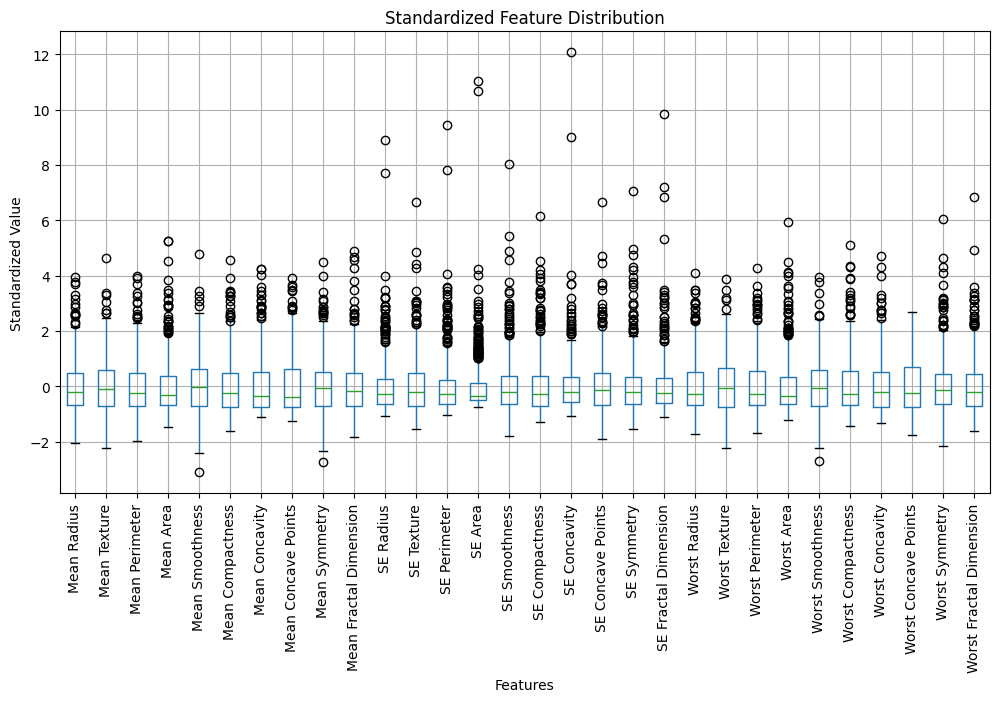

In [6]:
# 转换为 DataFrame
df_scaled = pd.DataFrame(X_scaled, columns=X.columns)

plt.figure(figsize=(12, 6))
df_scaled.boxplot(rot=90)
plt.title("Standardized Feature Distribution")
plt.xlabel("Features")
plt.ylabel("Standardized Value")
plt.show()


In [7]:
# 4. 数据集划分
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
# 5. 训练随机森林模型
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_rf

0.9736842105263158

In [9]:
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



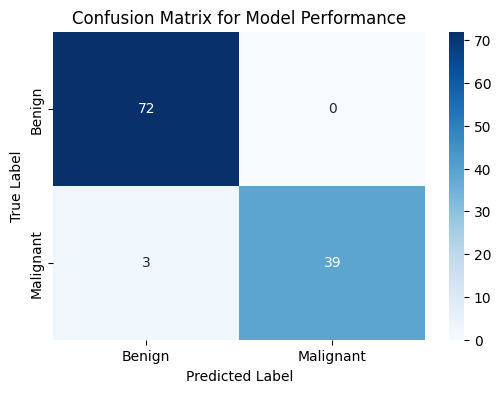

In [10]:
# 生成混淆矩阵图
conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.title("Confusion Matrix for Model Performance")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

<ipython-input-11-4a834f59319d>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df_rf[:10], x="Importance", y="Feature", palette="Blues_r")


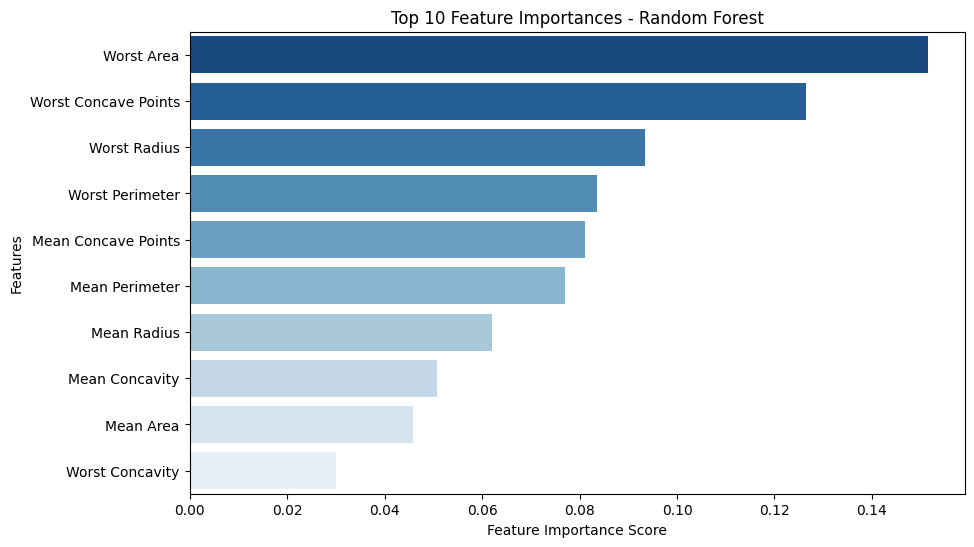

In [11]:
# 计算随机森林的特征重要性
feature_importances_rf = rf_model.feature_importances_
feature_importance_df_rf = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importances_rf
}).sort_values(by="Importance", ascending=False)

# 绘制 Random Forest 特征重要性
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df_rf[:10], x="Importance", y="Feature", palette="Blues_r")
plt.title("Top 10 Feature Importances - Random Forest")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()

In [12]:
# 6. 训练逻辑回归模型
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
accuracy_lr

0.9649122807017544

In [13]:
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97        72
           1       0.97      0.93      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



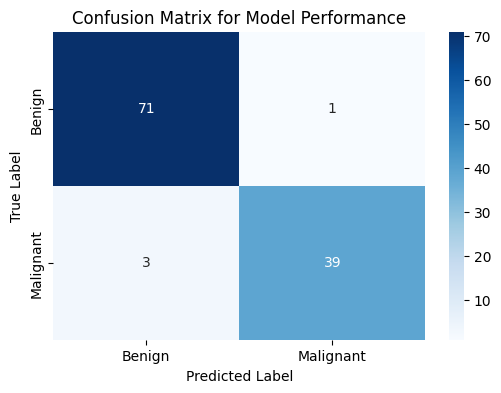

In [14]:
# 生成混淆矩阵图
conf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Benign", "Malignant"], yticklabels=["Benign", "Malignant"])
plt.title("Confusion Matrix for Model Performance")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

<ipython-input-15-6e226fc22a35>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df_lr[:10], x="Importance", y="Feature", palette="Reds_r")


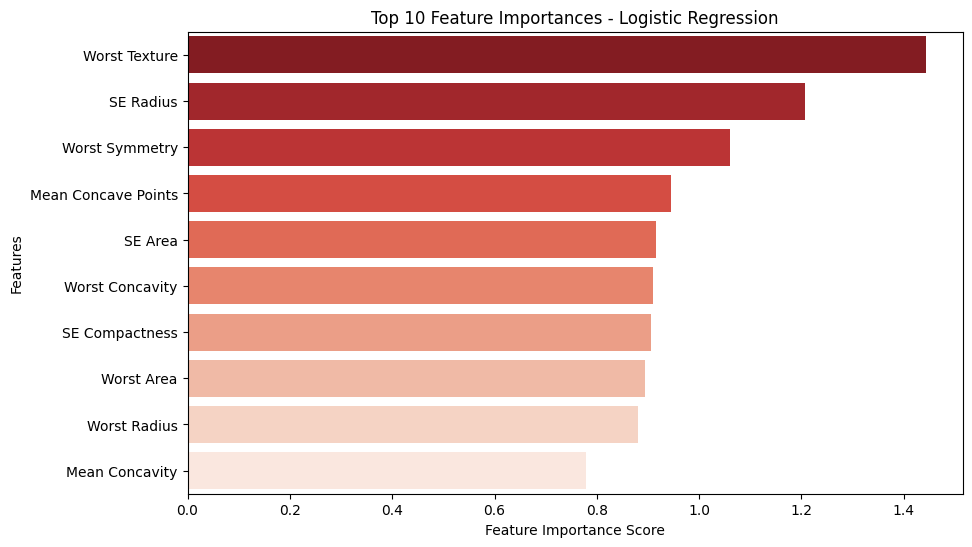

In [15]:
# 计算逻辑回归的特征重要性（取绝对值的系数）
feature_importances_lr = np.abs(lr_model.coef_)[0]
feature_importance_df_lr = pd.DataFrame({
    "Feature": X.columns,
    "Importance": feature_importances_lr
}).sort_values(by="Importance", ascending=False)

# 绘制 Logistic Regression 特征重要性
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df_lr[:10], x="Importance", y="Feature", palette="Reds_r")
plt.title("Top 10 Feature Importances - Logistic Regression")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()

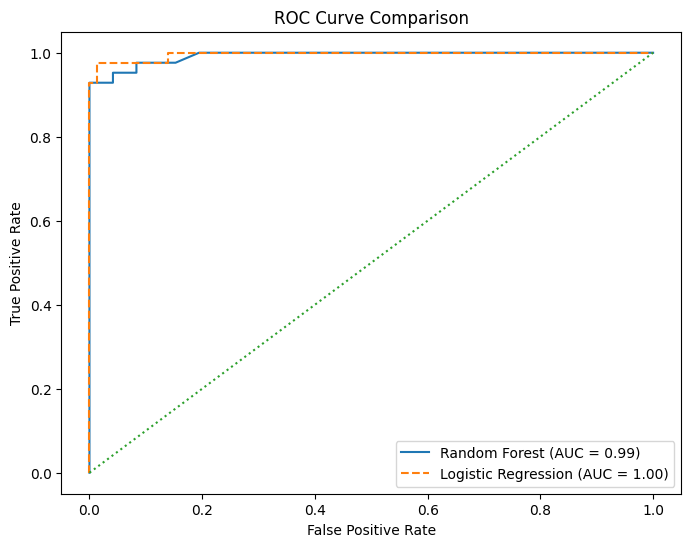

In [16]:
# 7. 计算 ROC 曲线
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
y_prob_lr = lr_model.predict_proba(X_test)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# 8. 绘制 ROC 曲线对比
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {roc_auc_rf:.2f})", linestyle="-")
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {roc_auc_lr:.2f})", linestyle="--")
plt.plot([0, 1], [0, 1], linestyle=":")  # 对角线
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

<Figure size 800x600 with 0 Axes>

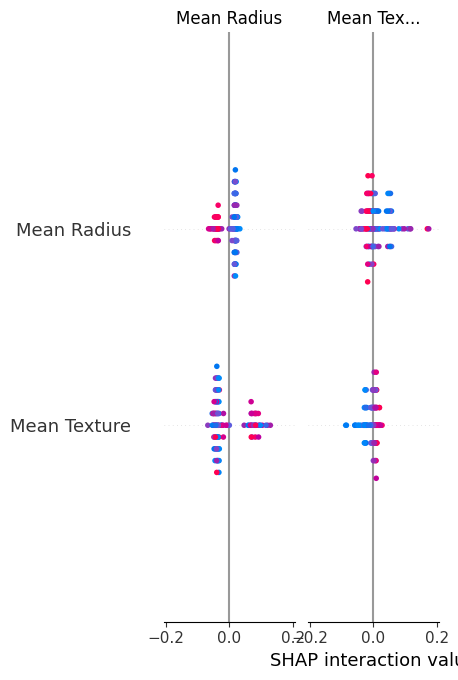

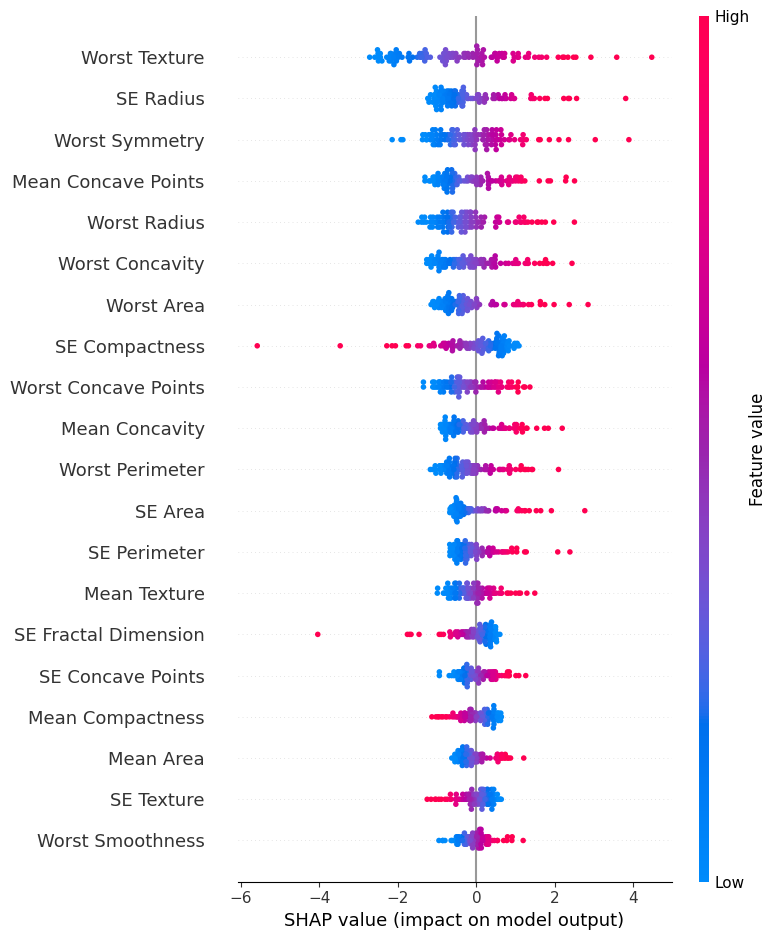

In [27]:
# 9. SHAP 解释
shap.initjs()

# 解释 Random Forest
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)
plt.figure(figsize=(8, 6))
shap.summary_plot(shap_values_rf[1] if isinstance(shap_values_rf, list) else shap_values_rf, X_test, feature_names=X.columns)

# 解释 Logistic Regression
explainer_lr = shap.LinearExplainer(lr_model, X_train)
shap_values_lr = explainer_lr.shap_values(X_test)
shap.summary_plot(shap_values_lr, X_test, feature_names=X.columns)  # 对逻辑回归的 SHAP 分析

In [18]:
# 10. LIME 解释
lime_explainer_rf = lime.lime_tabular.LimeTabularExplainer(
    X_train, feature_names=X.columns, class_names=["Benign", "Malignant"], discretize_continuous=True
)

lime_explainer_lr = lime.lime_tabular.LimeTabularExplainer(
    X_train, feature_names=X.columns, class_names=["Benign", "Malignant"], discretize_continuous=True
)

# 选取一个随机样本进行解释
idx = np.random.randint(0, X_test.shape[0])
sample = X_test[idx].reshape(1, -1)

# LIME 解释 - Random Forest
lime_exp_rf = lime_explainer_rf.explain_instance(sample[0], rf_model.predict_proba, num_features=5)
print("\nLIME Explanation for Random Forest:")
lime_exp_rf.show_in_notebook()

# LIME 解释 - Logistic Regression
lime_exp_lr = lime_explainer_lr.explain_instance(sample[0], lr_model.predict_proba, num_features=5)
print("\nLIME Explanation for Logistic Regression:")
lime_exp_lr.show_in_notebook()

# 11. 输出模型准确率对比
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f}")



LIME Explanation for Random Forest:



LIME Explanation for Logistic Regression:


Random Forest Accuracy: 0.9737
Logistic Regression Accuracy: 0.9649
